In [28]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import the necessary packages

In [29]:
target_column = "loan_status"

In [30]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

In [31]:
def removeArtifacts(data, original):
    for col in data.select_dtypes(include='object').columns:
        data[col] = data[col].where(data[col].isin(original[col].unique()), np.nan)
# remove categorical artifacts

In [32]:
def handleOriginal(original, test_df):
    original.insert(0, 'id', range(test_df['id'].max()+1, test_df['id'].max() + 1 + len(original)))

In [33]:
original = pd.read_csv("original.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train['dataset'] = 'train'
test['dataset'] = 'test'
original['dataset'] = 'original'

handleOriginal(original, test)

data = pd.concat([train, test, original]).reset_index(drop=True)

In [34]:
data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,dataset
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.0,train
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0,train
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.0,train
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0.0,train
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0.0,train


In [35]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          32581 non-null  int64  
 1   person_age                  32581 non-null  int64  
 2   person_income               32581 non-null  int64  
 3   person_home_ownership       32581 non-null  object 
 4   person_emp_length           31686 non-null  float64
 5   loan_intent                 32581 non-null  object 
 6   loan_grade                  32581 non-null  object 
 7   loan_amnt                   32581 non-null  int64  
 8   loan_int_rate               29465 non-null  float64
 9   loan_status                 32581 non-null  int64  
 10  loan_percent_income         32581 non-null  float64
 11  cb_person_default_on_file   32581 non-null  object 
 12  cb_person_cred_hist_length  32581 non-null  int64  
 13  dataset                     325

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
 13  dataset                     586

In [37]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
 12  dataset                     39098 non-null  object 
dtypes: float64(3), int64(5), object

In [38]:
data.isna().sum().sort_values(ascending=False)

loan_status                   39098
loan_int_rate                  3116
person_emp_length               895
id                                0
person_age                        0
person_income                     0
person_home_ownership             0
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
dataset                           0
dtype: int64

In [39]:
def show_missing_values(data, palette="viridis"):
    missing_values = data.isna().sum().sort_values(ascending=False)
    sns.barplot(x=missing_values.values, y=missing_values.index,palette=palette)

<Axes: xlabel='dataset', ylabel='count'>

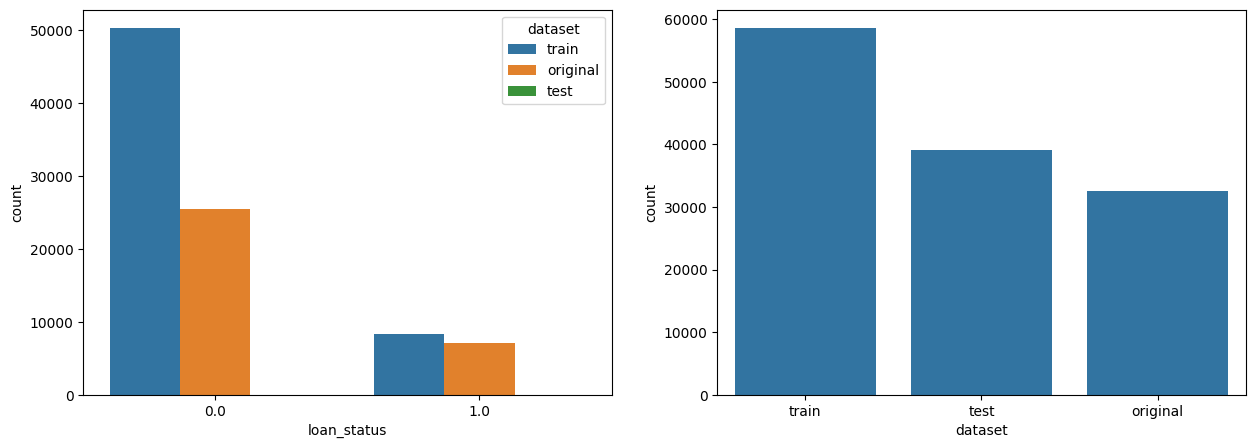

In [40]:
fig,axs = plt.subplots(figsize=(15,5),ncols=2)

sns.countplot(data,x="loan_status",hue="dataset",ax=axs[0])
sns.countplot(data, x='dataset',ax=axs[1])

<Axes: xlabel='cb_person_default_on_file', ylabel='count'>

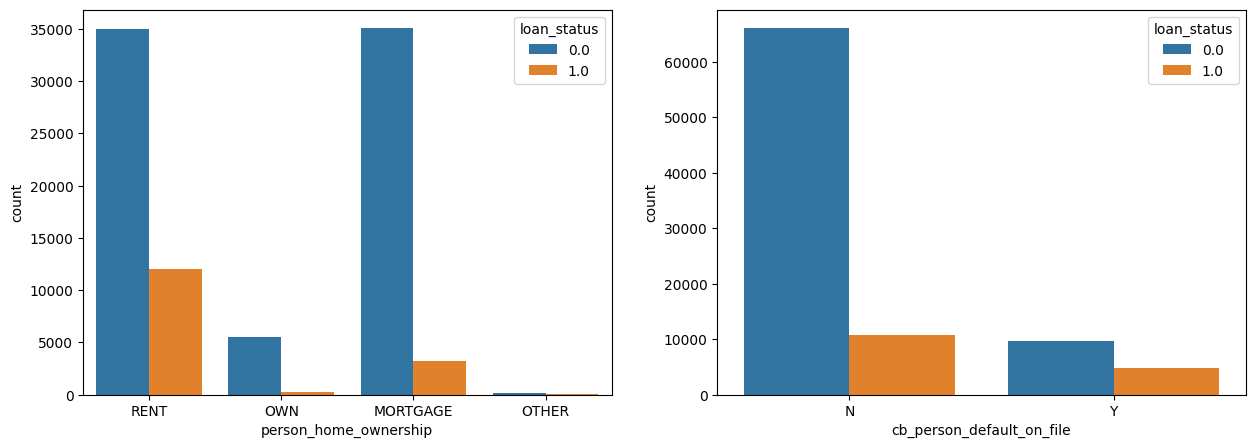

In [41]:
fig,axs = plt.subplots(figsize=(15,5),ncols=2)

sns.countplot(data, x="person_home_ownership",hue=target_column,ax=axs[0])
sns.countplot(data, x="cb_person_default_on_file",hue=target_column,ax=axs[1])

<Axes: xlabel='loan_grade', ylabel='count'>

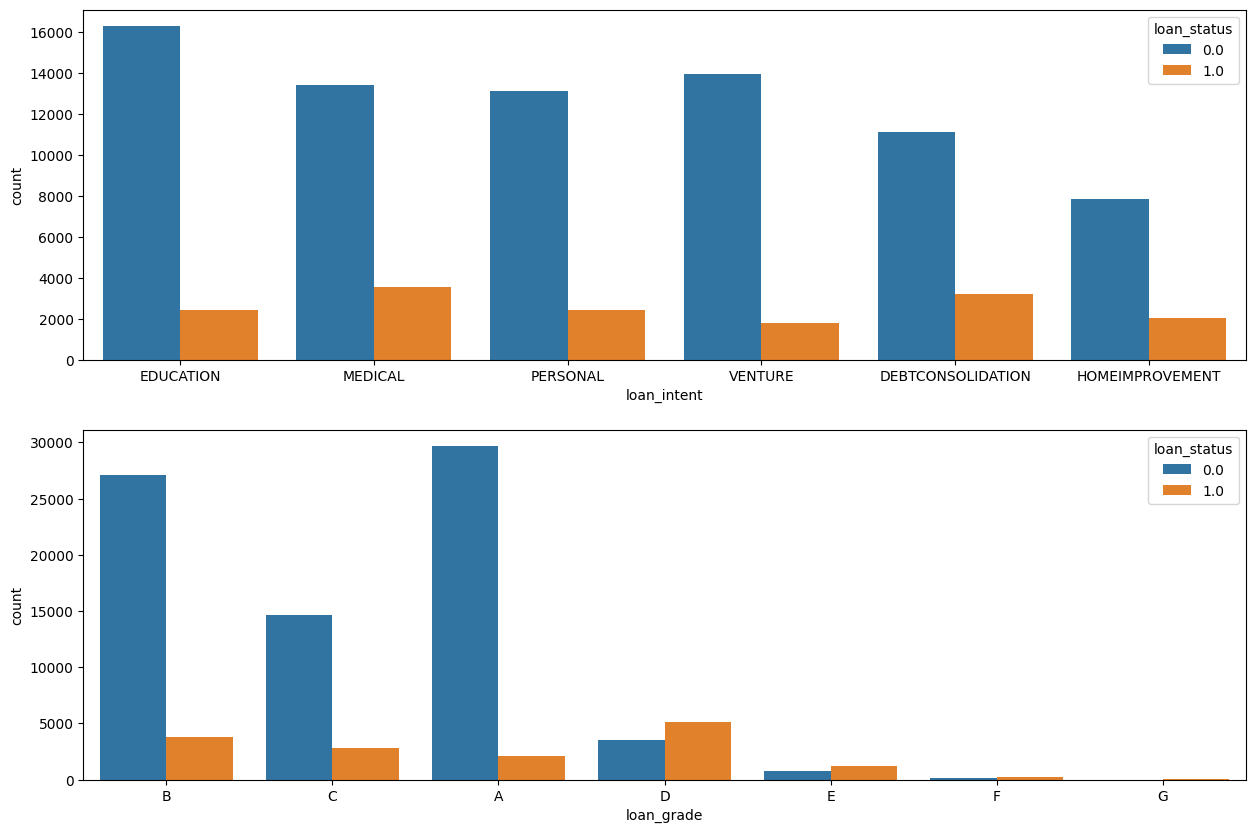

In [42]:
fig,axs = plt.subplots(figsize=(15,10),nrows=2)
sns.countplot(data, x="loan_intent",hue=target_column,ax=axs[0])
sns.countplot(data, x="loan_grade",hue=target_column,ax=axs[1])

<Axes: xlabel='cb_person_cred_hist_length'>

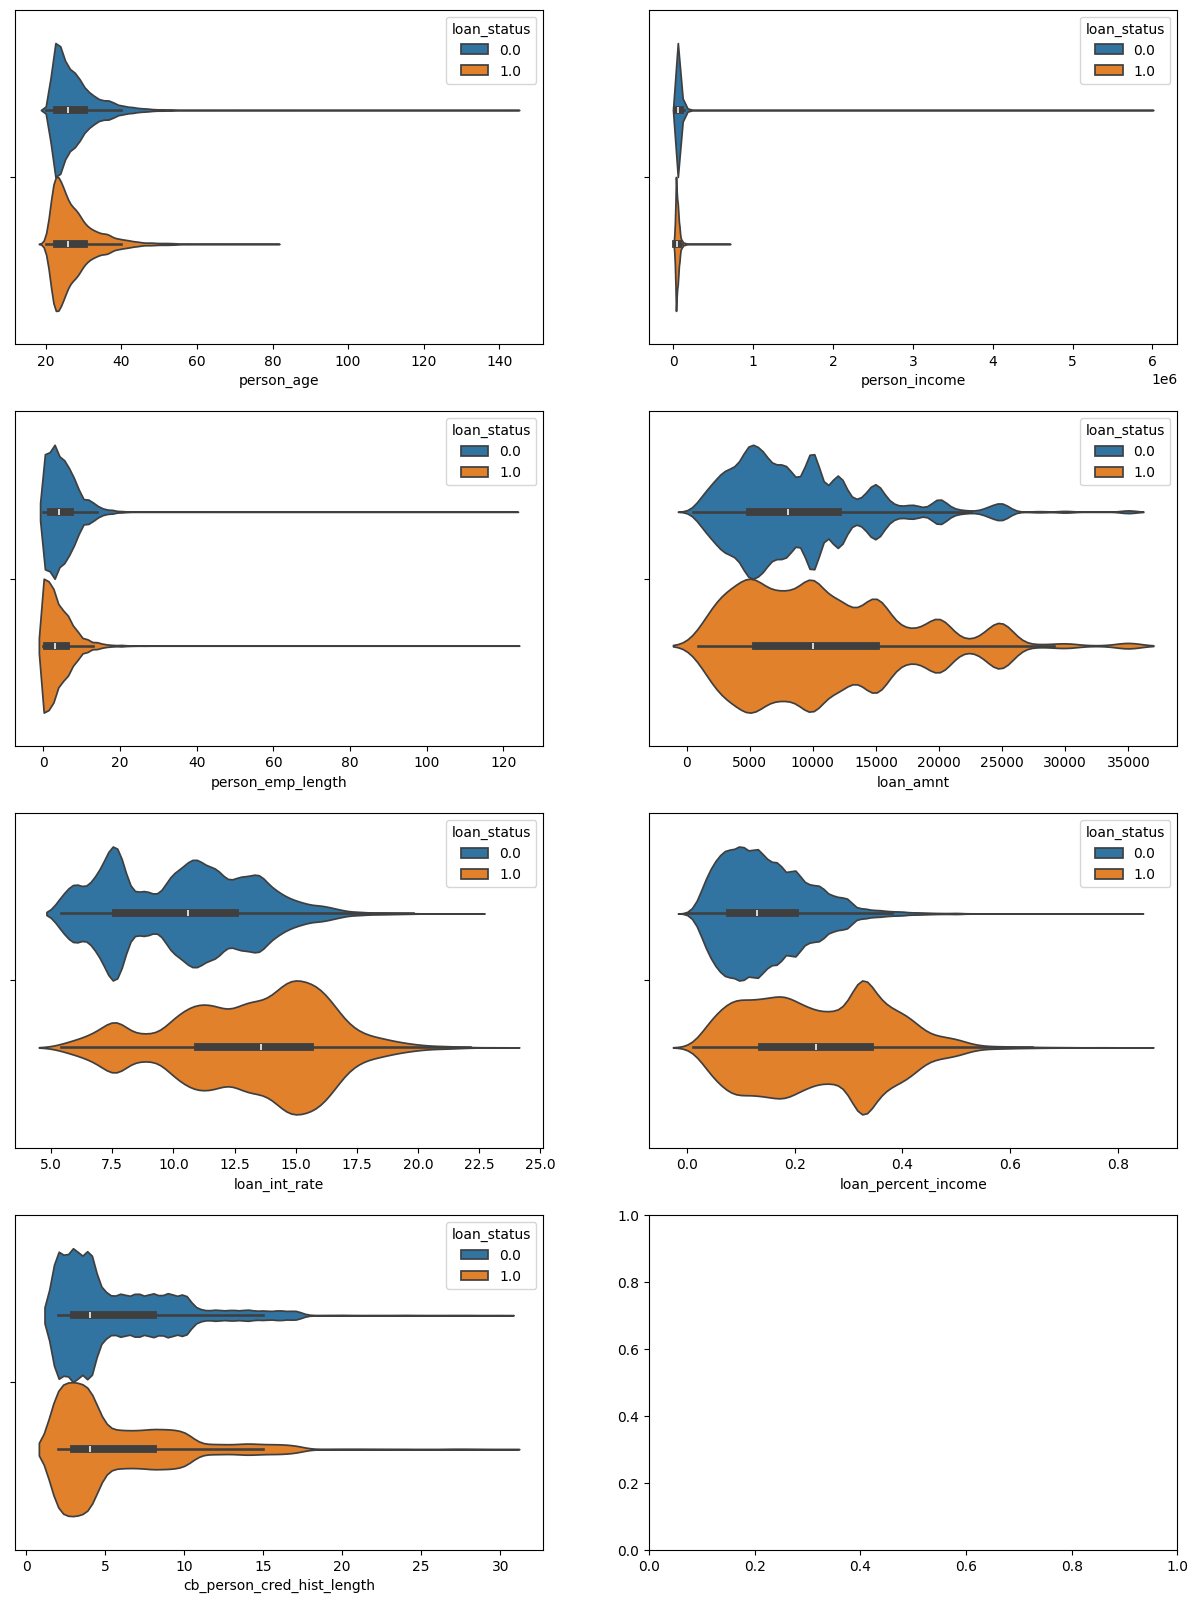

In [43]:
fig, axs = plt.subplots(figsize=(15,20),nrows=4, ncols=2)

sns.violinplot(data, x="person_age",hue=target_column,ax=axs[0][0])
sns.violinplot(data, x="person_income",hue=target_column,ax=axs[0][1])
sns.violinplot(data, x="person_emp_length",hue=target_column,ax=axs[1][0])
sns.violinplot(data, x="loan_amnt",hue=target_column,ax=axs[1][1])
sns.violinplot(data, x="loan_int_rate",hue=target_column,ax=axs[2][0])
sns.violinplot(data, x="loan_percent_income",hue=target_column,ax=axs[2][1])
sns.violinplot(data, x="cb_person_cred_hist_length",hue=target_column,ax=axs[3][0])

In [44]:
train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [45]:
test.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,78193.500000,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,11286.764749,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,58645.000000,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,68419.250000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,78193.500000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,87967.750000,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,97742.000000,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [46]:
original.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,114033.000000,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,9405.468897,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,97743.000000,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,105888.000000,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,114033.000000,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,122178.000000,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,130323.000000,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


<Axes: xlabel='cb_person_default_on_file', ylabel='count'>

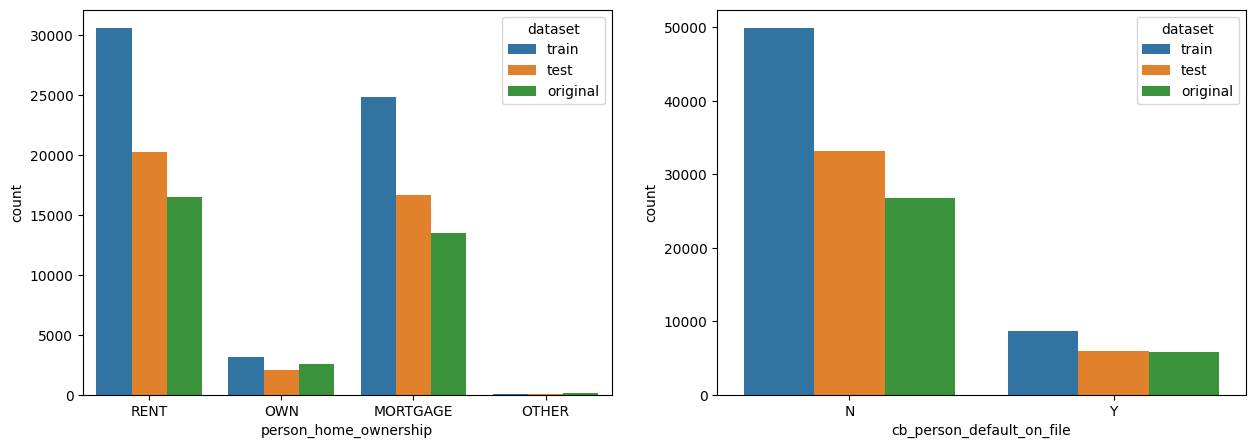

In [47]:
fig,axs = plt.subplots(figsize=(15,5),ncols=2)

sns.countplot(data, x="person_home_ownership",hue='dataset',ax=axs[0])
sns.countplot(data, x="cb_person_default_on_file",hue='dataset',ax=axs[1])

<Axes: xlabel='loan_grade', ylabel='count'>

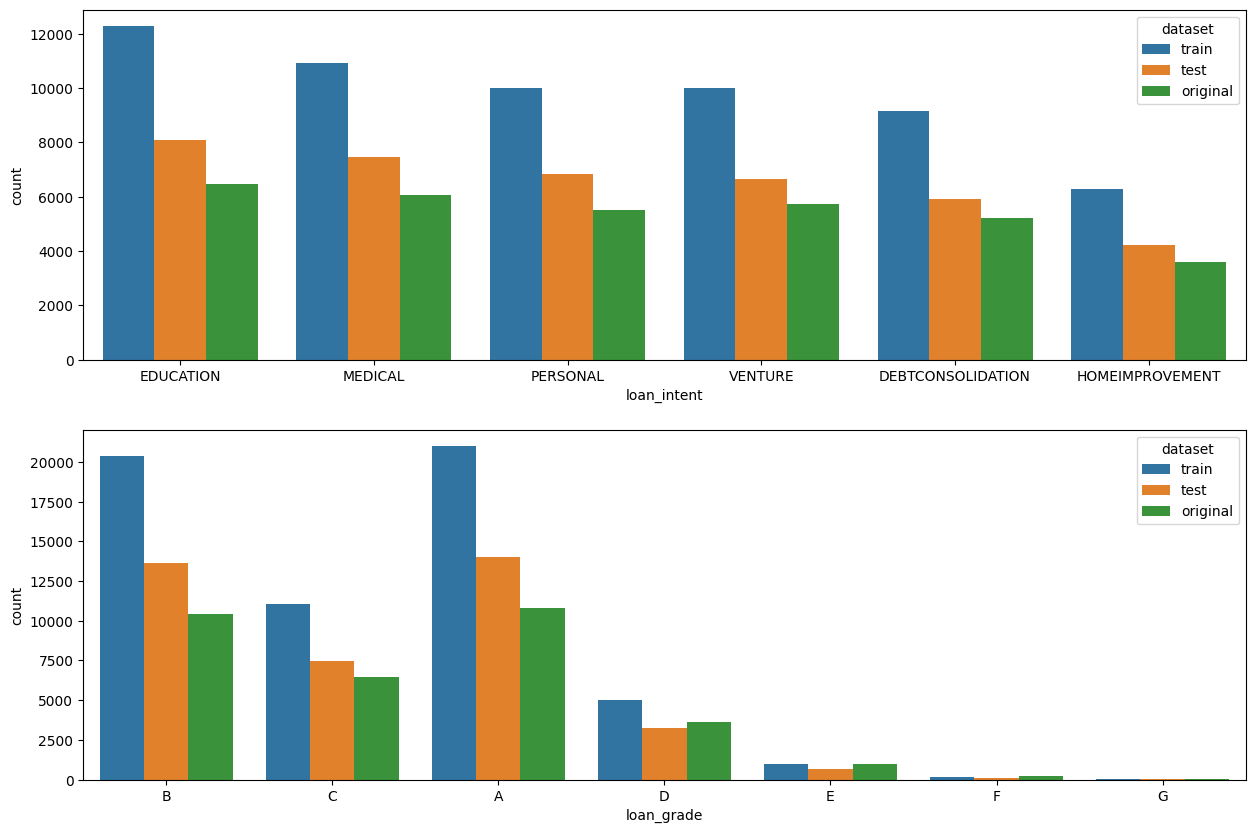

In [48]:
fig,axs = plt.subplots(figsize=(15,10),nrows=2)
sns.countplot(data, x="loan_intent",hue='dataset',ax=axs[0])
sns.countplot(data, x="loan_grade",hue='dataset',ax=axs[1])

<Axes: xlabel='cb_person_cred_hist_length'>

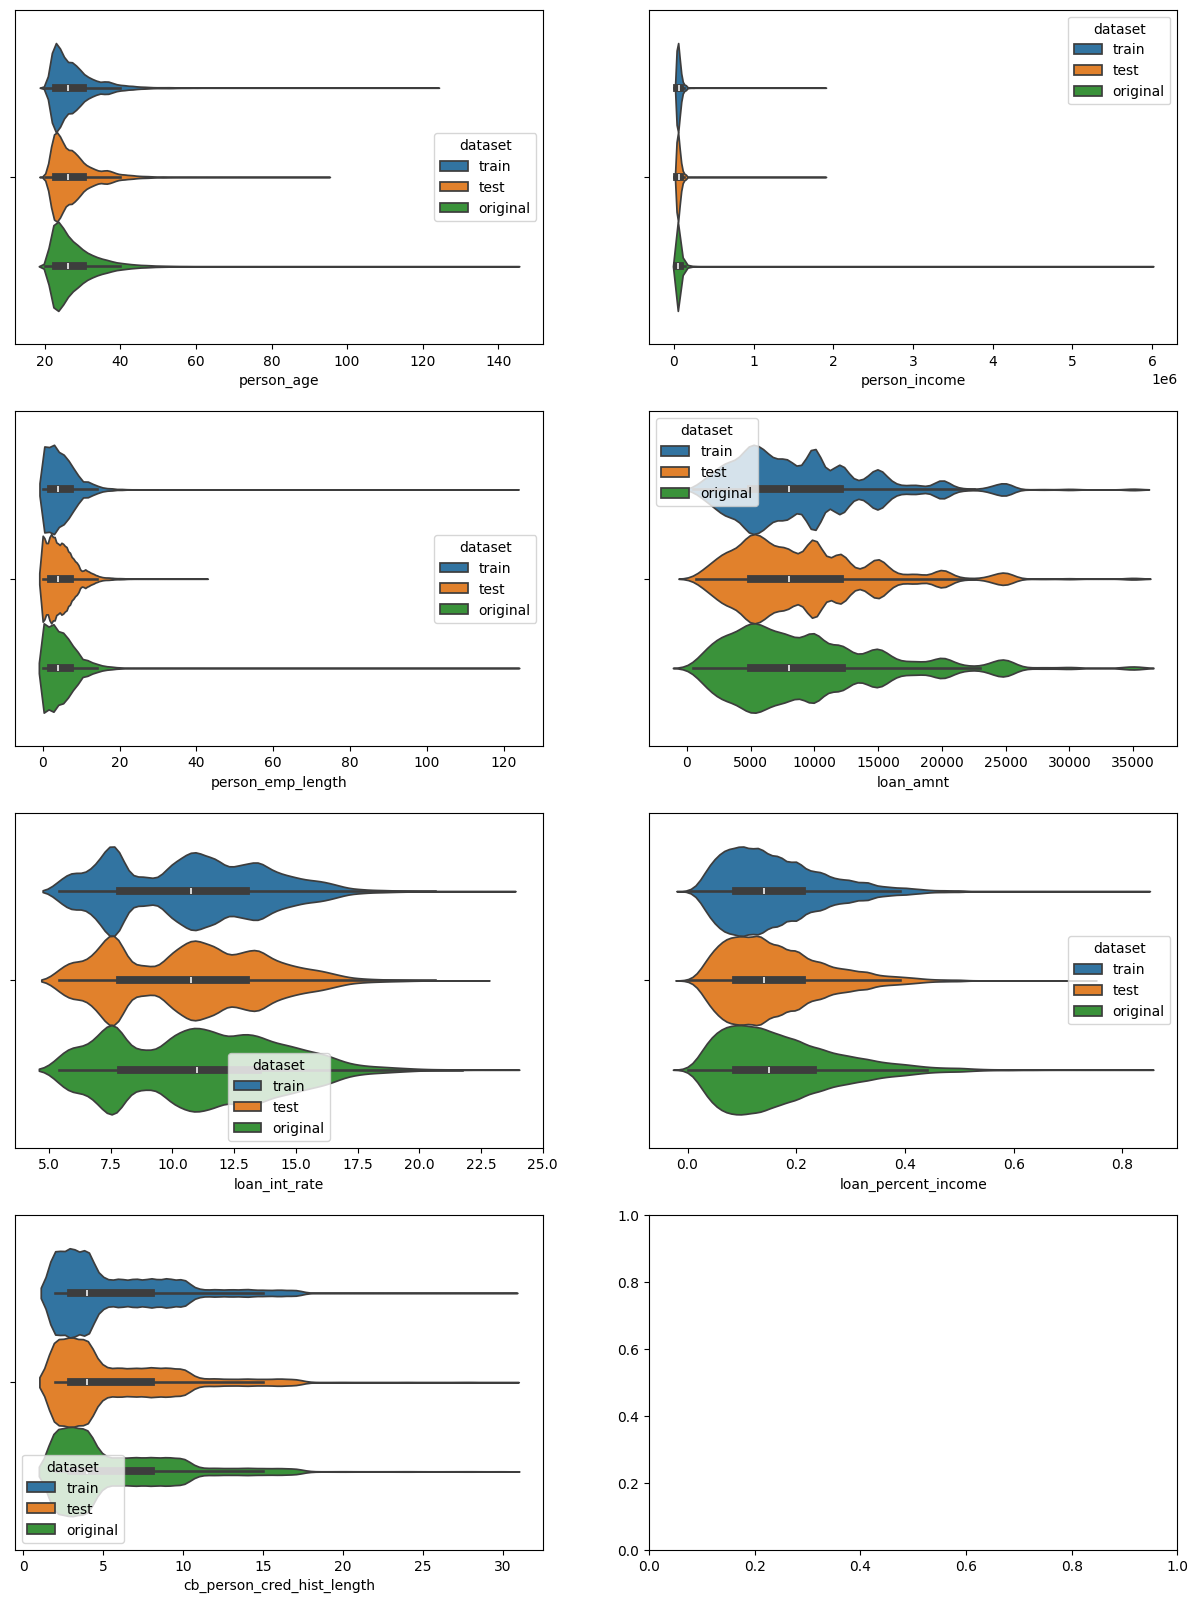

In [49]:
fig, axs = plt.subplots(figsize=(15,20),nrows=4, ncols=2)

sns.violinplot(data, x="person_age",hue='dataset',ax=axs[0][0])
sns.violinplot(data, x="person_income",hue='dataset',ax=axs[0][1])
sns.violinplot(data, x="person_emp_length",hue='dataset',ax=axs[1][0])
sns.violinplot(data, x="loan_amnt",hue='dataset',ax=axs[1][1])
sns.violinplot(data, x="loan_int_rate",hue='dataset',ax=axs[2][0])
sns.violinplot(data, x="loan_percent_income",hue='dataset',ax=axs[2][1])
sns.violinplot(data, x="cb_person_cred_hist_length",hue='dataset',ax=axs[3][0])

In [50]:
data['loan_grade'] = data['loan_grade'].replace({'G': 'F'})